# Text Models with Keras


## Dense vector word embeddings

A _dense vector_ word embedding means we represent words with number-full numerical vectors-- most components are nonzero.  This is in contrast to  _sparse vector_, or bag-of-word embeddings, which have very high-dimensional vectors (the size of the vocabulary) yet with most components zero.

Dense vector models also capture word meaning, such that similar words (car and automobile) have similar numerical vectors.  In a sparse vector representation, similar words probably have completely different numerical vectors.  **Dense vectors are formed as a by-product of some prediction task.**  The quality of the embedding depends on both the prediction task and the data set upon which the prediction task was trained. 

When we use word embeddings in our deep learning models, we refer to their birthplace as the _embedding layer_.  Sometimes, we don't actually care about the trained predictor (skip-gram and cbow models); we're just interested in the embeddings by-product for use elsewhere.  Other times, we need an embedding layer to represent words in a larger model such as a sentiment classifier; there, we may opt for pre-trained dense vectors.  

When we don't care about the trained model and just want to create meaningful, dense word vectors, there are two popular prediction models: **skip-gram** and **CBOW** (continuous bag of words).  Word embeddings constructed in this manner are termed **word2vec** or **w2v**.  We will also look at another more recent method, **fastText**.  In any case, we've first got to construct training data from our corpus.  The exact procedure depends on the model.

### Models and Training data construction

The first step for **CBOW** and **skip-gram**

Our training corpus is a collection of sentences, Tweets, emails, comments, or even longer documents.  It is something composed of words.  Each word takes is turn being the "target" word, and we collect the _n_ words behind it and _n_ words which follow it.  This _n_ is referred to as **window size**.  If our example document is the sentence "I love deep learning" and the window size is 1, we'd get:
  * **I**, love
  * I, **love**, deep
  * love, **deep**, learning
  * deep, **learning**
  
The target word is bold.

#### Skip-gram model training data

Skip-gram means form word pairs with a target word and all words in the window.  These become the "positive" (1) samples for the skip-gram algorithm.  In our "I love deep learning" example we'd get (eliminating repeated pairs):

  * (I, love) = 1
  * (love, deep) = 1
  * (deep, learning) = 1
  
To create negative samples (0), we pair random vocabulary words with the target word.  Yes, it's possible to unluckily pick a negative sample that usually appears around the target word.

For our prediction task, we'll take the dot product of the words in each pair (a small step away from the cosine similarity).  The training will keep tweaking the word vectors to make this product as close to unity as possible for our positive samples, and zero for our negative samples.

Happily, Keras include a function for creating skipgrams from text.  It even does the negative sampling for us.

In [1]:
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

Using TensorFlow backend.


In [2]:
text1 = "I love deep learning."
text2 = "Read Douglas Adams as much as possible."

In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text1, text2])

In [4]:
word2id = tokenizer.word_index
word2id.items()

[('love', 2),
 ('adams', 3),
 ('i', 4),
 ('possible', 5),
 ('deep', 6),
 ('read', 7),
 ('as', 1),
 ('much', 8),
 ('douglas', 9),
 ('learning', 10)]

Note word id's are numbered from 1, not zero

In [5]:
id2word = { wordid: word for word, wordid in word2id.items()}
id2word

{1: 'as',
 2: 'love',
 3: 'adams',
 4: 'i',
 5: 'possible',
 6: 'deep',
 7: 'read',
 8: 'much',
 9: 'douglas',
 10: 'learning'}

In [6]:
encoded_text = [word2id[word] for word in text_to_word_sequence(text1)]
encoded_text

[4, 2, 6, 10]

In [7]:
sg = skipgrams(encoded_text, vocabulary_size=len(word2id.keys()), window_size=1)
sg

([[2, 9],
  [6, 9],
  [6, 3],
  [6, 2],
  [2, 6],
  [2, 5],
  [10, 2],
  [4, 6],
  [2, 4],
  [10, 6],
  [6, 10],
  [4, 2]],
 [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1])

In [8]:
for i in range(len(sg[0])):
    print "({0},{1})={2}".format(id2word[sg[0][i][0]], id2word[sg[0][i][1]], sg[1][i])

(love,douglas)=0
(deep,douglas)=0
(deep,adams)=0
(deep,love)=1
(love,deep)=1
(love,possible)=0
(learning,love)=0
(i,deep)=0
(love,i)=1
(learning,deep)=1
(deep,learning)=1
(i,love)=1


Model parameters

In [9]:
VOCAB_SIZE = len(word2id.keys())
VOCAB_SIZE

10

In [10]:
DENSEVEC_DIM = 50

Model build

In [11]:
import keras

In [192]:
from keras.layers.embeddings import Embedding
from keras.constraints import unit_norm
from keras.layers.merge import Dot
from keras.layers.core import Activation
from keras.layers.core import Flatten

from keras.layers import Input
from keras.models import Model

Create a dense vector for each word in the pair.  The output of `Embedding` has shape `(batch_size, sequence_length, output_dim)` which in our case is `(batch_size, 1, DENSEVEC_DIM)`.  We'll use `Flatten` to get rid of that pesky middle dimension (1), so going into the dot product we'll have shape `(batch_size, DENSEVEC_DIM)`.

In [184]:
word1 = Input(shape=(1,), dtype='int64', name='word1')
word2 = Input(shape=(1,), dtype='int64', name='word2')

In [200]:
shared_embedding = Embedding(
    input_dim=VOCAB_SIZE+1, 
    output_dim=DENSEVEC_DIM, 
    input_length=1, 
    embeddings_constraint = unit_norm(),
    name='shared_embedding')

embedded_w1 = shared_embedding(word1)
embedded_w2 = shared_embedding(word2)

w1 = Flatten()(embedded_w1)
w2 = Flatten()(embedded_w2)

dotted = Dot(axes=1, name='dot_product')([w1, w2])

prediction = Activation('sigmoid', name='output_layer')(dotted)

In [201]:
sg_model = Model(inputs=[word1, word2], outputs=prediction)

In [202]:
sg_model.compile(optimizer='adam', loss='mean_squared_error')

At this point you can check out how the data flows through your compiled model.

In [203]:
sg_model.layers

In [304]:
def print_layer(model, num):
    print model.layers[num]
    print model.layers[num].input_shape
    print model.layers[num].output_shape

In [305]:
print_layer(sg_model,5)

[(None, 50), (None, 50)]
(None, 1)


Let's try training it with our toy data set!

In [206]:
import numpy as np

In [207]:
pairs = np.array(sg[0])
targets = np.array(sg[1])

In [208]:
targets

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1])

In [209]:
pairs

array([[ 2,  9],
       [ 6,  9],
       [ 6,  3],
       [ 6,  2],
       [ 2,  6],
       [ 2,  5],
       [10,  2],
       [ 4,  6],
       [ 2,  4],
       [10,  6],
       [ 6, 10],
       [ 4,  2]])

In [210]:
w1_list = np.reshape(pairs[:, 0], (len(pairs), 1))
w1_list

array([[ 2],
       [ 6],
       [ 6],
       [ 6],
       [ 2],
       [ 2],
       [10],
       [ 4],
       [ 2],
       [10],
       [ 6],
       [ 4]])

In [211]:
w2_list = np.reshape(pairs[:, 1], (len(pairs), 1))
w2_list

array([[ 9],
       [ 9],
       [ 3],
       [ 2],
       [ 6],
       [ 5],
       [ 2],
       [ 6],
       [ 4],
       [ 6],
       [10],
       [ 2]])

In [212]:
w2_list.shape

(12, 1)

In [213]:
w2_list.dtype

dtype('int64')

In [247]:
sg_model.fit(x=[w1_list, w2_list], y=targets,  epochs=10)

Epoch 1/10
12/12 [==============================] - 0s - loss: 0.0126
Epoch 2/10
12/12 [==============================] - 0s - loss: 0.0125
Epoch 3/10
12/12 [==============================] - 0s - loss: 0.0125
Epoch 4/10
12/12 [==============================] - 0s - loss: 0.0124
Epoch 5/10
12/12 [==============================] - 0s - loss: 0.0123
Epoch 6/10
12/12 [==============================] - 0s - loss: 0.0123
Epoch 7/10
12/12 [==============================] - 0s - loss: 0.0122
Epoch 8/10
12/12 [==============================] - 0s - loss: 0.0122
Epoch 9/10
12/12 [==============================] - 0s - loss: 0.0121
Epoch 10/10
12/12 [==============================] - 0s - loss: 0.0120


#### Continuous Bag of Words (CBOW) model 

CBOW means we take _all_ the words in the window and use them to predict the target word.  Note we are trying to predict an actual word (or a probability distribution over words) with CBOW, whereas in skip-gram we are trying to predict a similarity score. 

#### FastText Model

FastText is creating dense document vectors using the words in the document enhanced with n-grams.  These are embedded, averaged, and fed through a hidden dense layer, with a sigmoid activation.  The prediction task is some binary classification of the documents.  As usual, after training we can extract the dense vectors from the model.

#### FastText Model Data Prep

In [291]:
MAX_FEATURES = 20000  # number of unique words in the dataset
MAXLEN = 400  # max word (feature) length of a review  
EMBEDDING_DIMS = 50
NGRAM_RANGE = 2

Some data prep functions lifted from the example

In [260]:
def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))

In [262]:
create_ngram_set([1, 2, 3, 4, 5], ngram_value=2)

{(1, 2), (2, 3), (3, 4), (4, 5)}

In [263]:
create_ngram_set([1, 2, 3, 4, 5], ngram_value=3)

{(1, 2, 3), (2, 3, 4), (3, 4, 5)}

In [264]:
def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for i in range(len(new_list) - ngram_range + 1):
            for ngram_value in range(2, ngram_range + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

In [269]:
sequences = [[1,2,3,4,5], [6,7,8]]
token_indice = {(1,2): 20000, (4,5): 20001, (6,7,8): 20002}

In [270]:
add_ngram(sequences, token_indice, ngram_range=2)

[[1, 2, 3, 4, 5, 20000, 20001], [6, 7, 8]]

In [271]:
add_ngram(sequences, token_indice, ngram_range=3)

[[1, 2, 3, 4, 5, 20000], [6, 7, 8, 20002]]

load canned training data

In [274]:
from keras.datasets import imdb

In [275]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MAX_FEATURES)

In [276]:
x_train[0:2]

array([ list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8

In [277]:
y_train[0:2]

array([1, 0])

Add n-gram features

In [281]:
ngram_set = set()
for input_list in x_train:
    for i in range(2, NGRAM_RANGE + 1):
        set_of_ngram = create_ngram_set(input_list, ngram_value=i)
        ngram_set.update(set_of_ngram)

In [283]:
len(ngram_set)

1185229

Assign id's to the new features

In [285]:
start_index = MAX_FEATURES + 1
token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
indice_token = {token_indice[k]: k for k in token_indice}

Update MAX_FEATURES

In [292]:
MAX_FEATURES = np.max(list(indice_token.keys())) + 1
MAX_FEATURES

1205230

Add n-grams to the input data

In [288]:
x_train = add_ngram(x_train, token_indice, NGRAM_RANGE)
x_test = add_ngram(x_test, token_indice, NGRAM_RANGE)

Make all input sequences the same length by padding with zeros

In [293]:
from keras.preprocessing import sequence

In [295]:
sequence.pad_sequences([[1,2,3,4,5], [6,7,8]], maxlen=10)

array([[0, 0, 0, 0, 0, 1, 2, 3, 4, 5],
       [0, 0, 0, 0, 0, 0, 0, 6, 7, 8]], dtype=int32)

In [296]:
x_train = sequence.pad_sequences(x_train, maxlen=MAXLEN)
x_test = sequence.pad_sequences(x_test, maxlen=MAXLEN)

In [297]:
x_train.shape

(25000, 400)

In [298]:
x_test.shape

(25000, 400)

#### FastText Model

In [299]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers import Dense

In [300]:
ft_model = Sequential()

ft_model.add(Embedding(
    input_dim = MAX_FEATURES,
    output_dim = EMBEDDING_DIMS,
    input_length= MAXLEN))

ft_model.add(GlobalAveragePooling1D())

ft_model.add(Dense(1, activation='sigmoid'))

In [301]:
ft_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [302]:
ft_model.layers

In [306]:
print_layer(ft_model, 0)

(None, 400)
(None, 400, 50)


In [307]:
print_layer(ft_model, 1)

(None, 400, 50)
(None, 50)


In [308]:
print_layer(ft_model, 2)

(None, 50)
(None, 1)


In [310]:
ft_model.fit(x_train, y_train, batch_size=100, epochs=3, validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 212s - loss: 0.6614 - acc: 0.7317 - val_loss: 0.6059 - val_acc: 0.8069
Epoch 2/3
25000/25000 [==============================] - 210s - loss: 0.5023 - acc: 0.8827 - val_loss: 0.4631 - val_acc: 0.8567
Epoch 3/3
25000/25000 [==============================] - 207s - loss: 0.3363 - acc: 0.9321 - val_loss: 0.3735 - val_acc: 0.8788


#### Our own data download and preparation

We'll use the [Large Movie Review Dataset v1.0](http://ai.stanford.edu/~amaas/data/sentiment/) for our corpus.  While Keras has its own data samples you can import for modeling (including this one), I think it's very important to get and process your own data.  Otherwise, the results appear to materialize out of thin air and it's more difficult to get on with your own research.

In [42]:
%matplotlib inline
import pandas as pd

In [14]:
import glob

In [51]:
datapath = "/Users/pfigliozzi/aclImdb/train/unsup"
files = glob.glob(datapath+"/*.txt")[:1000] #first 1000 (there are 50k)

In [52]:
df = pd.concat([pd.read_table(filename, header=None, names=['raw']) for filename in files], ignore_index=True)  

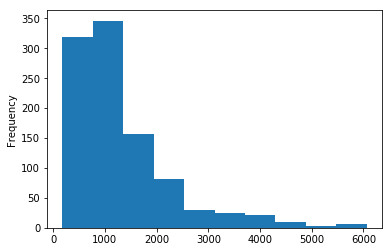

In [53]:
df.raw.map(lambda x: len(x)).plot.hist()

In [47]:
50000. * 2000. / 10**6

100.0